In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import pickle

In [ ]:
PREPROCESSED_DATA_PATH = '/kaggle/input/genres-other-no-metacritic-preprocessed/preprocessed.parquet'

In [ ]:
df = pd.read_parquet(PREPROCESSED_DATA_PATH)

In [ ]:
X = df.drop(columns=['copiesSold'])
Y = df['copiesSold']

In [ ]:
pd.set_option('display.max_columns', None)
X.head()

In [ ]:
Y.head()

In [ ]:
Y.describe()

In [ ]:
models = {
    'LinearRegression': LinearRegression(n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=6, random_state=42)
}

In [ ]:
test_feature_counts = list(range(1, X.shape[1]+1, 1))

In [ ]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)
scoring = 'r2'

In [ ]:
results = {}

for model_name, model in models.items():
    model_scores = []
    selected_features_per_n = []

    print(f"\nRunning RFE for model: {model_name}")

    for n_features in test_feature_counts:
        if model_name in ['RandomForest', 'XGBoost']:
            rfe = RFE(estimator=model, n_features_to_select=n_features, step=1, verbose=1, importance_getter='feature_importances_')
        else:
            rfe = RFE(estimator=model, n_features_to_select=n_features, step=1, verbose=1)
        
        # Fit RFE to training data
        rfe.fit(X, Y)
        
        # Get mask of selected features
        selected_mask = rfe.support_
        selected_features = X.columns[selected_mask]
        selected_features_per_n.append(selected_features)

        # Evaluate only selected features via cross-validation
        X_selected = X.loc[:, selected_mask]
        score = cross_val_score(model, X_selected, Y, cv=cv, scoring=scoring, n_jobs=-1)
        mean_score = score.mean()
        model_scores.append(mean_score)

        # Debug print
        print(f"\n[{model_name}] Selected {n_features} features")
        print(f"Cross-validated R²: {mean_score}")
        
    results[model_name] = {
        'scores': model_scores,
        'features': selected_features_per_n
    }

In [ ]:
with open('/kaggle/working/rfe_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [1]:
for model_name, model_data in results.items():
    print(f"\n=== Results for {model_name} ===")
    scores = model_data['scores']
    feature_sets = model_data['features']
    
    for n, (score, features) in zip(test_feature_counts, zip(scores, feature_sets)):
        print(f"\n→ Number of Features: {n}")
        print(f"R² Score: {score:.4f}")
        print(f"Selected Features ({len(features)}): {list(features)}")


=== Results for LinearRegression ===

→ Number of Features: 1
R² Score: 0.1250
Selected Features (1): ['publisherClass_Other']

→ Number of Features: 2
R² Score: 0.3621
Selected Features (2): ['publisherClass_Indie', 'publisherClass_Other']

→ Number of Features: 3
R² Score: 0.4474
Selected Features (3): ['genre_Free To Play', 'publisherClass_Indie', 'publisherClass_Other']

→ Number of Features: 4
R² Score: 0.4740
Selected Features (4): ['has_metacritic', 'genre_Free To Play', 'publisherClass_Indie', 'publisherClass_Other']

→ Number of Features: 5
R² Score: 0.4761
Selected Features (5): ['workshop_support', 'has_metacritic', 'genre_Free To Play', 'publisherClass_Indie', 'publisherClass_Other']

→ Number of Features: 6
R² Score: 0.4897
Selected Features (6): ['steam_trading_cards', 'workshop_support', 'has_metacritic', 'genre_Free To Play', 'publisherClass_Indie', 'publisherClass_Other']

→ Number of Features: 7
R² Score: 0.4917
Selected Features (7): ['steam_trading_cards', 'worksho

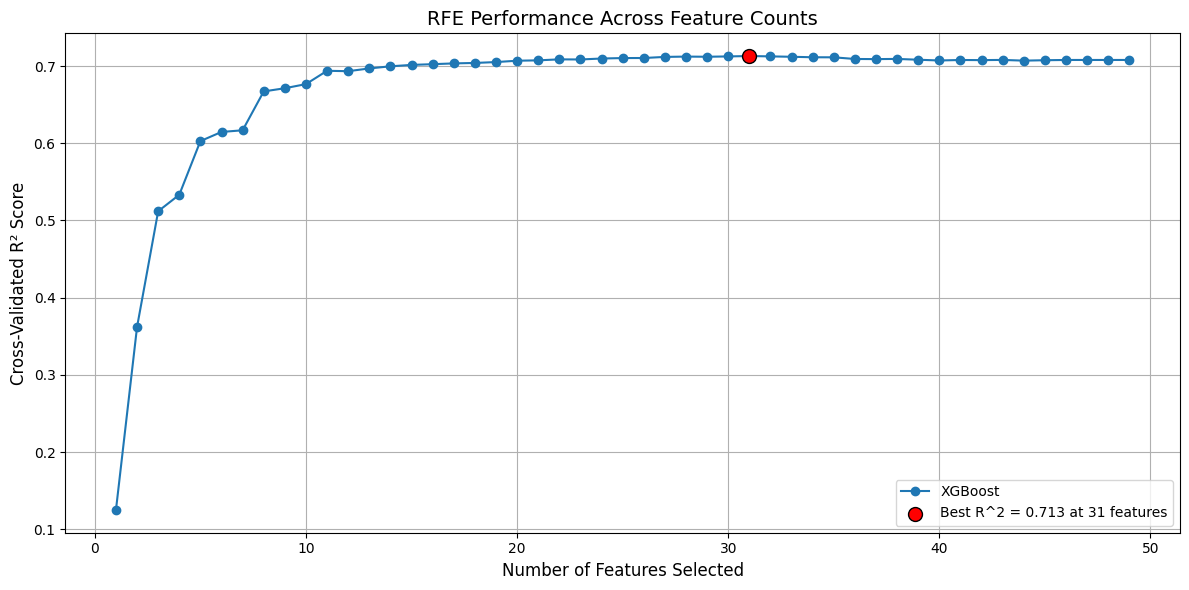

In [19]:
plt.figure(figsize=(12, 6))
model_name = 'XGBoost'

best_idx = np.argmax(results[model_name]['scores'])
best_score = results[model_name]['scores'][best_idx]
best_n_features = test_feature_counts[best_idx]

plt.plot(test_feature_counts, results[model_name]['scores'], marker='o', label=model_name)
plt.scatter([best_n_features], [best_score], color='red', label=f'Best R^2 = {best_score:.3f} at {best_n_features} features', s=100, edgecolors='black', zorder=3)

plt.xlabel("Number of Features Selected", fontsize=12)
plt.ylabel("Cross-Validated R² Score", fontsize=12)
plt.title("RFE Performance Across Feature Counts", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

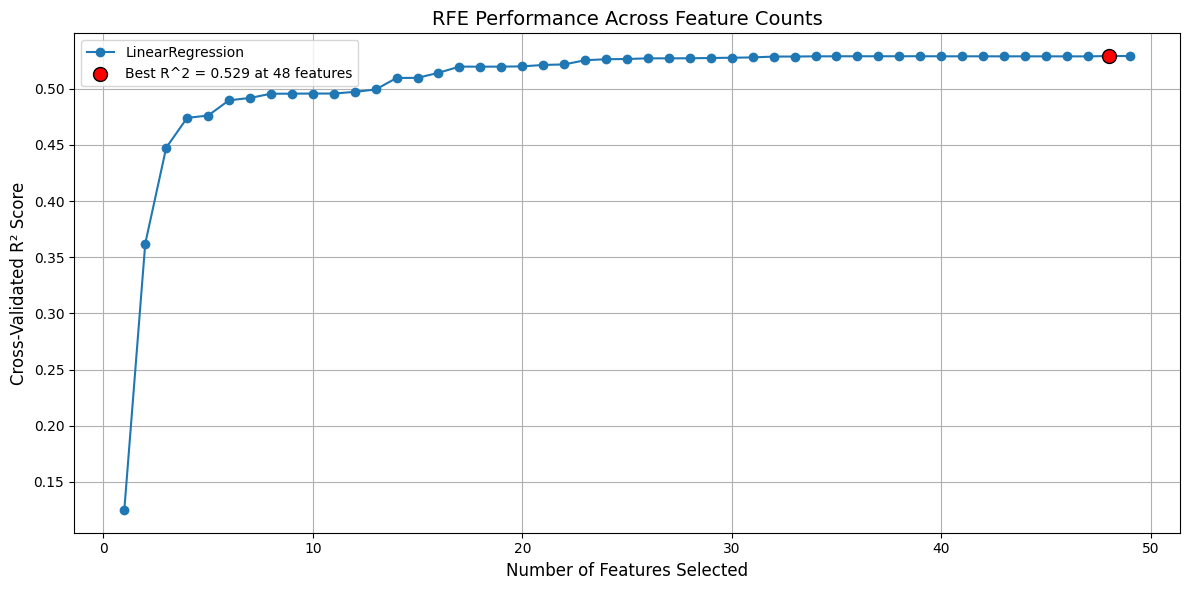

In [18]:
plt.figure(figsize=(12, 6))
model_name = 'LinearRegression'

best_idx = np.argmax(results[model_name]['scores'])
best_score = results[model_name]['scores'][best_idx]
best_n_features = test_feature_counts[best_idx]

plt.plot(test_feature_counts, results[model_name]['scores'], marker='o', label=model_name)
plt.scatter([best_n_features], [best_score], color='red', label=f'Best R^2 = {best_score:.3f} at {best_n_features} features', s=100, edgecolors='black', zorder=3)

plt.xlabel("Number of Features Selected", fontsize=12)
plt.ylabel("Cross-Validated R² Score", fontsize=12)
plt.title("RFE Performance Across Feature Counts", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()